# Top2Vec to conduct Topic Modelling on Coursera Data

We will first cluster the topics within each program: Then, we will vectorise the module summaries, do dimensionality reduction before using HDBSCAN to generate the topics. Then, it will extract the top 5-10 keywords per topic (exact number to be determined after fine-tuning) using c-TF-IDF.

The difference between using Top2Vec compared to using BERT is that keyword extraction is done by taking the keyword vectors that are closest to the topic centroid.

# 1.0 Importing Libraries and Coursera Dataset

In [1]:
import pandas as pd
import numpy as np
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from gensim.models import CoherenceModel
from top2vec import Top2Vec
import time
import re
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import gensim.corpora as corpora
from tqdm.notebook import tqdm
import os
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

C:\Users\somes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2.0 Dataset Preprocessing

In [2]:
# Function to extract the documents from the corpus 
def load_program_documents(program_index):
    file_path = f"../corpus/program{program_index}.txt"
    if not os.path.exists(file_path):
        return []

    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Extract content inside <DOC>...</DOC>
    docs = re.findall(r'<DOC>(.*?)</DOC>', content, re.DOTALL)

    # Split each <DOC> block by line and clean
    program_docs = []
    for doc in docs:
        segments = [segment.strip() for segment in doc.split('\n') if segment.strip()]
        program_docs.extend(segments)

    return program_docs


# 3.0 Training Pipeline

In [3]:
#Get the total number of documents
all_documents = []

for i in range(475):
    docs = load_program_documents(i)
    if docs:  # skip if empty
        all_documents.extend(docs)

print(f"Total documents: {len(all_documents)}")

# Train the top2vec model
model = Top2Vec(
    documents=all_documents,
    embedding_model="doc2vec",
    speed="learn",
    workers=4,
    min_count=1
)

model.save("saved models/top2vec_model")

2025-03-29 12:03:42,785 - top2vec - INFO - Pre-processing documents for training


Total documents: 37285


2025-03-29 12:03:50,972 - top2vec - INFO - Creating joint document/word embedding
2025-03-29 12:09:11,138 - top2vec - INFO - Creating lower dimension embedding of documents
2025-03-29 12:10:09,274 - top2vec - INFO - Finding dense areas of documents
2025-03-29 12:10:17,904 - top2vec - INFO - Finding topics


# 4.0 Coherence Scoring

In [4]:
# Get topic words from Top2Vec
model = Top2Vec.load("saved models/top2vec_model")
topic_words, word_scores, topic_scores = model.get_topics()

# Preview the first topic
print("Sample raw topic from Top2Vec:")
print(topic_words[0])
print()
print("Sample score from Top2Vec:")
print(word_scores[0])

Sample raw topic from Top2Vec:
['margas' 'fizzbuzz' 'loops' 'accumulator' 'strings' 'fstrings' 'tuples'
 'dictionaries' 'lists' 'vowelword' 'switchcase' 'dorsa' 'encapusulation'
 'arrays' 'thonnys' 'ternaryoperator' 'nested' 'chained' 'strreplacefirst'
 'nonmutating' 'shortcircuit' 'hashmaps' 'functions' 'informat' 'forloop'
 'whileloop' 'unrecoverable' 'breakstatement' 'whilecode' 'sortvector'
 'strreplaceall' 'ksmallest' 'dowhile' 'strsplit' 'string' 'oddball'
 'diagonal' 'unary' 'multivalued' 'python' 'booleans' 'overloaded'
 'spawns' 'collisionfree' 'toppings' 'loop' 'ifthenelse' 'mlogic' 'tuple'
 'structures']

Sample score from Top2Vec:
[0.67445785 0.6703005  0.665778   0.6292792  0.6239724  0.6228134
 0.62219024 0.6119361  0.61104095 0.6080748  0.5711738  0.56971484
 0.5646659  0.55987746 0.5559645  0.5532783  0.55065256 0.5452094
 0.53593177 0.53566885 0.5341832  0.53205013 0.53186727 0.5287027
 0.5283356  0.5278654  0.526445   0.5254443  0.5212354  0.5190281
 0.51837444 0.5145

In [5]:
tokenized = [doc.lower().split() for doc in all_documents]
from gensim.corpora import Dictionary
dictionary = Dictionary(tokenized)

In [6]:
# Compute the coherence score
coherence_model = CoherenceModel(
    topics=topic_words,
    texts=tokenized,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print(f"✅ Top2Vec Global Coherence Score (c_v): {coherence_score:.4f}")

✅ Top2Vec Global Coherence Score (c_v): 0.3376


# 5.0 Visualisation

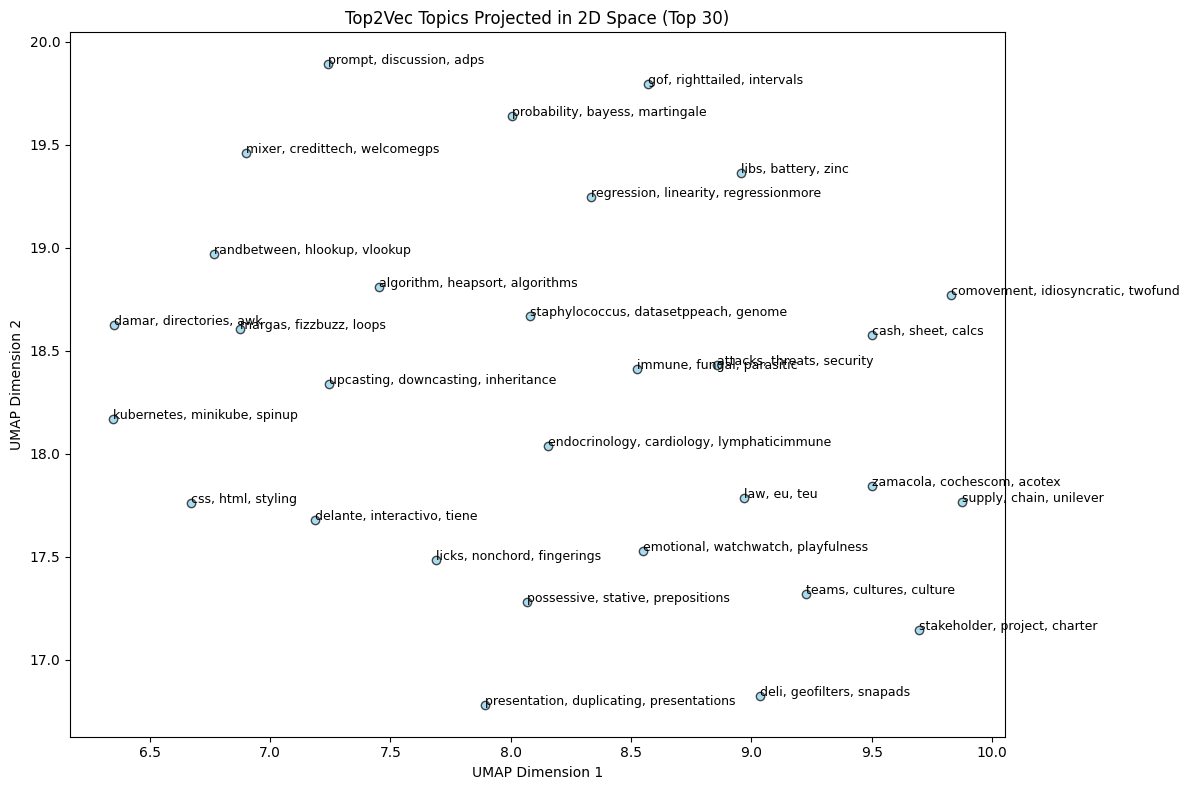

In [11]:
from umap import UMAP

model = Top2Vec.load("saved models/top2vec_model")

# Step 1: Get topic words and scores from get_topics()
topic_words, word_scores, topic_nums = model.get_topics()

# Step 2: Get the top N topic indices
top_n = 30
top_topic_nums = topic_nums[:top_n]  # assumes topic_nums are sorted by importance

# Step 3: Get corresponding vectors and labels
topic_vectors = model.topic_vectors[top_topic_nums]

# Generate short 3-word labels using topic_words (aligned with top_topic_nums)
topic_labels = [
    ', '.join(topic_words[i][:3]) for i in top_topic_nums
]

# Step 4: UMAP projection
umap_model = UMAP(n_components=2, random_state=42)
coords = umap_model.fit_transform(topic_vectors)

# Step 5: Plot
plt.figure(figsize=(12, 8))
plt.scatter(coords[:, 0], coords[:, 1], c='skyblue', edgecolors='k', alpha=0.7)

for i, label in enumerate(topic_labels):
    plt.text(coords[i, 0], coords[i, 1], label, fontsize=9)

plt.title("Top2Vec Topics Projected in 2D Space (Top 30)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()

In [13]:
topic_words, word_scores, topic_nums = model.get_topics()

for i, topic_num in enumerate(topic_nums[:5]):  # Top 5 topics
    print(f"\n🧠 Topic {topic_num}")
    for word, score in zip(topic_words[i], word_scores[i]):
        print(f"- {word} ({score:.3f})")


🧠 Topic 0
- margas (0.674)
- fizzbuzz (0.670)
- loops (0.666)
- accumulator (0.629)
- strings (0.624)
- fstrings (0.623)
- tuples (0.622)
- dictionaries (0.612)
- lists (0.611)
- vowelword (0.608)
- switchcase (0.571)
- dorsa (0.570)
- encapusulation (0.565)
- arrays (0.560)
- thonnys (0.556)
- ternaryoperator (0.553)
- nested (0.551)
- chained (0.545)
- strreplacefirst (0.536)
- nonmutating (0.536)
- shortcircuit (0.534)
- hashmaps (0.532)
- functions (0.532)
- informat (0.529)
- forloop (0.528)
- whileloop (0.528)
- unrecoverable (0.526)
- breakstatement (0.525)
- whilecode (0.521)
- sortvector (0.519)
- strreplaceall (0.518)
- ksmallest (0.515)
- dowhile (0.514)
- strsplit (0.514)
- string (0.513)
- oddball (0.511)
- diagonal (0.510)
- unary (0.508)
- multivalued (0.508)
- python (0.507)
- booleans (0.503)
- overloaded (0.503)
- spawns (0.502)
- collisionfree (0.499)
- toppings (0.498)
- loop (0.498)
- ifthenelse (0.496)
- mlogic (0.496)
- tuple (0.495)
- structures (0.495)

🧠 Topi

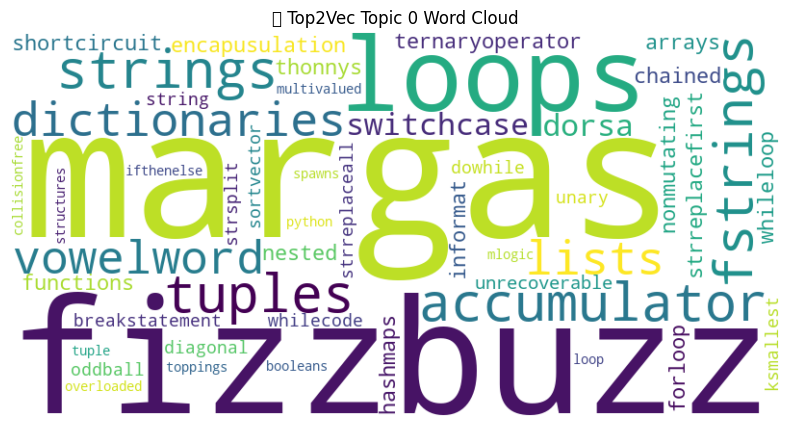

In [14]:
from wordcloud import WordCloud

# Example for topic 0
words_scores = dict(zip(topic_words[0], word_scores[0]))

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(words_scores)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("🧠 Top2Vec Topic 0 Word Cloud")
plt.show()